# Experiments - Physics-SR Framework v4.1 Benchmark

## Benchmark Experiment Execution Module

**Author:** Zhengze Zhang  
**Affiliation:** Department of Statistics, Columbia University  
**Contact:** zz3239@columbia.edu  
**Date:** January 2026  
**Version:** 4.1 (Structure-Guided Feature Library + Computational Optimization)

---

### Purpose

This notebook executes all benchmark experiments for the Physics-SR Framework v4.1.

### Experimental Design

**Core Experiments (96 runs):**
- 4 equations x 2 noise (0%, 5%) x 2 dummy (0, 5) x 2 dims (T/F) x 3 methods = 96

**Supplementary Experiments (8 runs):**
- 4 equations x 2 sample sizes (250, 750) x Physics-SR only = 8

**Total: 104 experiments**

### Test Equations (AI Feynman Benchmark)

| # | Name | AI Feynman ID | Type |
|---|------|---------------|------|
| 1 | Coulomb | I.12.2 | Rational |
| 2 | Cosines | I.29.16 | Nested trigonometric |
| 3 | Barometric | I.40.1 | Exponential |
| 4 | DotProduct | I.11.19 | Polynomial interaction |

---
## Section 1: Header and Imports

In [46]:
# ==============================================================================
# ENVIRONMENT RESET AND FRESH CLONE
# ==============================================================================

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    import os
    import shutil
    import gc

    try:
        os.chdir('/content')
    except:
        pass

    gc.collect()

    repo_path = '/content/Physics-Informed-Symbolic-Regression'
    if os.path.exists(repo_path):
        shutil.rmtree(repo_path)
        print("[OK] Removed existing repository.")

    !git clone https://github.com/Garthzzz/Physics-Informed-Symbolic-Regression.git

    if os.path.exists(repo_path):
        print("[OK] Fresh repository cloned.")
        os.chdir(repo_path + '/benchmark')
        print(f"[OK] Working directory: {os.getcwd()}")
        !git log --oneline -3
    else:
        print("[FAIL] Clone failed!")

    print("\n[OK] Environment reset complete.")
else:
    print("[INFO] Not in Colab environment.")

[OK] Removed existing repository.
Cloning into 'Physics-Informed-Symbolic-Regression'...
remote: Enumerating objects: 584, done.
remote: Counting objects: 100% (584/584), done.
remote: Compressing objects: 100% (401/401), done.
remote: Total 584 (delta 274), reused 489 (delta 181), pack-reused 0 (from 0)
Receiving objects: 100% (584/584), 7.52 MiB | 10.56 MiB/s, done.
Resolving deltas: 100% (274/274), done.
[OK] Fresh repository cloned.
[OK] Working directory: /content/Physics-Informed-Symbolic-Regression/benchmark
7dcbca1 (HEAD -> main, origin/main, origin/HEAD) fix
cb73745 FIX
1f6e512 fix

[OK] Environment reset complete.


In [47]:
# ==============================================================================
# COLAB SETUP - PySR Installation
# ==============================================================================

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    import os
    if not os.path.exists('/content/Physics-Informed-Symbolic-Regression'):
        !git clone https://github.com/Garthzzz/Physics-Informed-Symbolic-Regression.git
        print("Repository cloned!")

    %cd /content/Physics-Informed-Symbolic-Regression

    !pip install -q pysr
    import pysr
    pysr.install()

    from pathlib import Path
    data_files = list(Path('benchmark/data').glob('*.npz'))
    print(f"\nFound {len(data_files)} data files")

    if len(data_files) == 24:
        print("[OK] All data files present!")
    else:
        print(f"[WARNING] Expected 24 files, found {len(data_files)}")

    print("\nSetup complete!")

/content/Physics-Informed-Symbolic-Regression

Found 24 data files
[OK] All data files present!

Setup complete!


In [48]:
"""
Experiments.ipynb - Benchmark Experiment Execution Module
Physics-SR Framework v4.1 Benchmark Suite

Author: Zhengze Zhang
Contact: zz3239@columbia.edu
Version: 4.1
"""

import os
import sys
import re
import time
import pickle
import warnings
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any, Union
from dataclasses import dataclass, field, asdict

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm

warnings.filterwarnings('ignore')

print("Experiments v4.1: All imports successful.")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Experiments v4.1: All imports successful.
NumPy version: 2.0.2
Pandas version: 2.2.2


In [49]:
# ==============================================================================
# PATH CONFIGURATION
# ==============================================================================

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    BASE_DIR = Path('/content/Physics-Informed-Symbolic-Regression')
    ALGORITHMS_DIR = BASE_DIR / 'algorithms'
    BENCHMARK_DIR = BASE_DIR / 'benchmark'
else:
    BENCHMARK_DIR = Path('.').resolve()
    ALGORITHMS_DIR = BENCHMARK_DIR.parent / 'algorithms'
    BASE_DIR = BENCHMARK_DIR.parent

DATA_DIR = BENCHMARK_DIR / 'data'
RESULTS_DIR = BENCHMARK_DIR / 'results'

DATA_DIR.mkdir(exist_ok=True, parents=True)
RESULTS_DIR.mkdir(exist_ok=True, parents=True)

print(f"Environment: {'Google Colab' if IN_COLAB else 'Local'}")
print(f"Base directory: {BASE_DIR}")
print(f"Algorithms directory: {ALGORITHMS_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Results directory: {RESULTS_DIR}")

data_files = list(DATA_DIR.glob('*.npz'))
print(f"Found {len(data_files)} data files")

Environment: Google Colab
Base directory: /content/Physics-Informed-Symbolic-Regression
Algorithms directory: /content/Physics-Informed-Symbolic-Regression/algorithms
Data directory: /content/Physics-Informed-Symbolic-Regression/benchmark/data
Results directory: /content/Physics-Informed-Symbolic-Regression/benchmark/results
Found 24 data files


In [50]:
# ==============================================================================
# EXPERIMENT CONFIGURATION CONSTANTS (v4.1)
# ==============================================================================

EXPERIMENT_SEED = 42
TEST_SIZE = 0.2
METHODS = ['physics_sr', 'pysr_only', 'lasso_pysr']

PYSR_CONFIG = {
    'mode': 'fast',
    'timeout': 60,
}

PHYSICS_SR_CONFIG = {
    'screening_threshold': 0.8,
    'power_law_r2_threshold': 0.9,
    'interaction_stability': 0.5,
    'max_poly_degree': 3,
    'stlsq_threshold': 0.1,
    'pysr_maxsize': 18,
    'pysr_niterations': 30,
    'pysr_timeout': 60,
    'pysr_mode': 'fast',
    'generate_variants': True,
    'use_weak_form': True,
    'cv_folds': 5,
    'ebic_gamma': 0.5,
    'n_bootstrap': 50,
    'confidence_level': 0.95
}

LASSO_CONFIG = {
    'cv': 5,
    'max_iter': 10000,
}

EQUATION_INDEX_MAP = {
    'coulomb': 1,
    'cosines': 2,
    'barometric': 3,
    'dotproduct': 4
}

GROUND_TRUTH_REGISTRY = {
    'coulomb': {
        'ai_feynman_id': 'I.12.2',
        'equation': 'F = k * q1 * q2 / r**2',
        'active_features': ['q1', 'q2', 'r'],
        'type': 'rational'
    },
    'cosines': {
        'ai_feynman_id': 'I.29.16',
        'equation': 'x = sqrt(x1**2 + x2**2 - 2*x1*x2*cos(theta1-theta2))',
        'active_features': ['x1', 'x2', 'theta1', 'theta2'],
        'type': 'nested_trigonometric'
    },
    'barometric': {
        'ai_feynman_id': 'I.40.1',
        'equation': 'n = n0 * exp(-m*g*x/(k_b*T))',
        'active_features': ['n0', 'm', 'g', 'x', 'k_b', 'T'],
        'type': 'exponential'
    },
    'dotproduct': {
        'ai_feynman_id': 'I.11.19',
        'equation': 'A = x1*y1 + x2*y2 + x3*y3',
        'active_features': ['x1', 'x2', 'x3', 'y1', 'y2', 'y3'],
        'type': 'polynomial_interaction'
    }
}

print("Experiment configuration v4.1 loaded.")
print(f"Methods: {METHODS}")
print(f"Equations: {list(EQUATION_INDEX_MAP.keys())}")

Experiment configuration v4.1 loaded.
Methods: ['physics_sr', 'pysr_only', 'lasso_pysr']
Equations: ['coulomb', 'cosines', 'barometric', 'dotproduct']


In [51]:
# ==============================================================================
# EXPERIMENT CONFIGURATION GENERATORS (v4.1)
# ==============================================================================

def get_core_experiment_configs() -> List[Dict]:
    """
    Generate configurations for core experiments.
    Core: 4 equations x 2 noise x 2 dummy x 2 dims = 32 configurations
    With 3 methods each = 96 total experiments
    """
    configs = []
    equations = ['coulomb', 'cosines', 'barometric', 'dotproduct']
    noise_levels = [0.0, 0.05]
    dummy_counts = [0, 5]
    with_dims_options = [True, False]
    n_samples = 500

    for eq_name in equations:
        for noise in noise_levels:
            for n_dummy in dummy_counts:
                for with_dims in with_dims_options:
                    configs.append({
                        'equation_name': eq_name,
                        'n_samples': n_samples,
                        'noise_level': noise,
                        'n_dummy': n_dummy,
                        'with_dims': with_dims
                    })
    return configs


def get_supplementary_experiment_configs() -> List[Dict]:
    """
    Generate configurations for supplementary experiments.
    Supplementary: 4 equations x 2 sample sizes (250, 750) = 8 configurations
    """
    configs = []
    equations = ['coulomb', 'cosines', 'barometric', 'dotproduct']
    sample_sizes = [250, 750]

    for eq_name in equations:
        for n_samples in sample_sizes:
            configs.append({
                'equation_name': eq_name,
                'n_samples': n_samples,
                'noise_level': 0.05,
                'n_dummy': 5,
                'with_dims': True
            })
    return configs


print(f"Core experiment configs: {len(get_core_experiment_configs())}")
print(f"Supplementary experiment configs: {len(get_supplementary_experiment_configs())}")

Core experiment configs: 32
Supplementary experiment configs: 8


---
## Section 2: Algorithm Module Import

In [52]:
# ==============================================================================
# LOAD ALGORITHM MODULES
# ==============================================================================

print("Loading algorithm modules...")

%cd {ALGORITHMS_DIR}

%run 00_Core.ipynb
%run 01_BuckinghamPi.ipynb
%run 02_VariableScreening.ipynb
%run 03_SymmetryAnalysis.ipynb
%run 04_InteractionDiscovery.ipynb
%run 05_FeatureLibrary.ipynb
%run 06_PySR.ipynb
%run 07_EWSINDy_STLSQ.ipynb
%run 08_AdaptiveLasso.ipynb
%run 09_ModelSelection.ipynb
%run 10_PhysicsVerification.ipynb
%run 11_UQ_Inference.ipynb
%run 12_Full_Pipeline.ipynb

%cd {BENCHMARK_DIR}

print("\n" + "=" * 70)
print(" All algorithm modules loaded successfully!")
print("=" * 70)

Loading algorithm modules...
/content/Physics-Informed-Symbolic-Regression/algorithms
00_Core v4.1: All imports successful.
NumPy version: 2.0.2
Pandas version: 2.2.2
PySR available: True
Joblib available: True
Global configuration constants v4.1 defined.
PYSR_MODES available: ['fast', 'standard', 'thorough']
UserInputs dataclass defined.
Stage1Results dataclass defined.
Stage2Results dataclass v4.1 defined.
Stage3Results dataclass defined.
TimeBudgetManager class defined.
Safe numerical operations defined.
Metrics and evaluation functions defined.
Formatting and output functions defined.
Data preprocessing functions defined.
v4.1 memory and optimization utilities defined.
Warm rain data generator defined.
Polynomial data generator defined.
Trigonometric data generator defined.
Pendulum data generator defined.
 00_Core.ipynb v4.1 - Module Summary

DATACLASSES:
  - UserInputs: User-defined inputs (dimensions, bounds, mappings)
  - Stage1Results: Variable selection & preprocessing result

In [53]:
# ==============================================================================
# HOTFIX: BuckinghamPi High-Dimensional Fix (v4.1.1)
# ==============================================================================
# This patch fixes the exponential blowup in BuckinghamPiAnalyzer when
# n_vars > 6. Instead of brute-force enumeration (7^n combinations),
# we use SVD to compute the null space basis directly.
# ==============================================================================

print("Applying BuckinghamPi high-dimensional fix...")

# Store the original method
_original_enumerate_null_vectors = BuckinghamPiAnalyzer._enumerate_null_vectors

def _fast_enumerate_null_vectors(self, dim_matrix):
    """
    Fast null vector enumeration using SVD (v4.1.2 FIX).

    Always uses SVD instead of brute-force enumeration.

    The original brute-force method has O(9^n * m^2) complexity where:
    - n = number of variables
    - m = number of null vectors found

    When the dimension matrix has low rank (e.g., Cosines equation with
    rank=1 and 4 variables), the null space is 3-dimensional, causing
    massive slowdowns (441s for just 4 variables!).

    SVD directly computes the null space basis in O(n^3), avoiding the
    exponential enumeration entirely.
    """
    n_vars = dim_matrix.shape[1]

    # v4.1.2: Always use SVD-based approach (removed n_vars <= 6 check)
    U, S, Vh = np.linalg.svd(dim_matrix, full_matrices=True)

    # Find rank (number of non-zero singular values)
    tol = max(dim_matrix.shape) * np.finfo(float).eps * S[0] if len(S) > 0 else 1e-10
    rank = np.sum(S > tol)

    # Null space dimension
    null_dim = n_vars - rank

    if null_dim == 0:
        return []

    # Null space basis vectors (last rows of Vh)
    null_basis = Vh[rank:, :]  # Shape: (null_dim, n_vars)

    # Convert to list of vectors and try to find integer approximations
    candidates = []

    for i in range(null_basis.shape[0]):
        vec = null_basis[i]

        # Try to find integer approximation by scaling
        max_idx = np.argmax(np.abs(vec))
        if np.abs(vec[max_idx]) < 1e-10:
            continue

        # Scale so that max element is +/- max_exponent
        scaled = vec / np.abs(vec[max_idx]) * self.max_exponent

        # Round to nearest integers
        int_vec = np.round(scaled)

        # Verify it's still in null space
        if np.allclose(dim_matrix @ int_vec, 0, atol=1e-8):
            normalized = self._normalize_vector(int_vec)

            # Check for duplicates
            is_duplicate = False
            for existing in candidates:
                if np.allclose(normalized, existing) or np.allclose(-normalized, existing):
                    is_duplicate = True
                    break

            if not is_duplicate:
                candidates.append(normalized)

    # Also try linear combinations of null basis for better coverage
    if null_dim > 0 and len(candidates) < null_dim:
        for i in range(min(null_dim, 3)):
            for coef in [1, -1, 2, -2]:
                for j in range(null_basis.shape[0]):
                    if j == i:
                        continue
                    combined = null_basis[i] + coef * null_basis[j]
                    max_idx = np.argmax(np.abs(combined))
                    if np.abs(combined[max_idx]) < 1e-10:
                        continue
                    scaled = combined / np.abs(combined[max_idx]) * self.max_exponent
                    int_vec = np.round(scaled)

                    if np.allclose(dim_matrix @ int_vec, 0, atol=1e-8):
                        normalized = self._normalize_vector(int_vec)
                        is_duplicate = any(
                            np.allclose(normalized, ex) or np.allclose(-normalized, ex)
                            for ex in candidates
                        )
                        if not is_duplicate:
                            candidates.append(normalized)

    # If we found nothing, create trivial Pi groups for dimensionless dummies
    if len(candidates) == 0:
        for j in range(n_vars):
            col = dim_matrix[:, j]
            if np.allclose(col, 0):  # Dimensionless variable
                vec = np.zeros(n_vars)
                vec[j] = 1.0
                candidates.append(vec)

    return candidates

# Apply the patch
BuckinghamPiAnalyzer._enumerate_null_vectors = _fast_enumerate_null_vectors

print("  [OK] BuckinghamPi patched for high-dimensional cases (n_vars > 6)")
print("  [OK] SVD method used for ALL cases (v4.1.2 FIX)")

Applying BuckinghamPi high-dimensional fix...
  [OK] BuckinghamPi patched for high-dimensional cases (n_vars > 6)
  [OK] SVD method used for ALL cases (v4.1.2 FIX)


In [54]:
# ==============================================================================
# HOTFIX 2: Stage 1 Detailed Timing (v4.1.1)
# ==============================================================================
# This patch adds detailed timing breakdown for Stage 1 to diagnose slow runs.
# If Stage 1 takes > 15 seconds, it prints individual component times.
# ==============================================================================

print("Applying Stage 1 detailed timing fix...")

# Store original _run_stage1 method
_original_run_stage1 = PhysicsSRPipeline._run_stage1

def _patched_run_stage1(self, X, y, feature_names, user_inputs=None):
    """
    Patched Stage 1 with detailed timing breakdown.
    """
    import time

    # Run original method
    results = _original_run_stage1(self, X, y, feature_names, user_inputs)

    # Add detailed timing output if verbose and slow
    if self.config.get('verbose', True) and results.timing:
        timing = results.timing
        stage1_total = sum([
            timing.get('buckingham_pi', 0),
            timing.get('screening', 0),
            timing.get('symmetry', 0),
            timing.get('interaction', 0)
        ])

        # Show breakdown if any component took > 5s or total > 15s
        if stage1_total > 15:
            print(f"      [WARNING] Stage 1 slow ({stage1_total:.1f}s), breakdown:")
            print(f"        1.1 BuckinghamPi: {timing.get('buckingham_pi', 0):.1f}s")
            print(f"        1.2 Screening:    {timing.get('screening', 0):.1f}s")
            print(f"        1.3 Symmetry:     {timing.get('symmetry', 0):.1f}s")
            print(f"        1.4 Interaction:  {timing.get('interaction', 0):.1f}s")

    return results

# Apply patch
PhysicsSRPipeline._run_stage1 = _patched_run_stage1
print("  [OK] Stage 1 detailed timing enabled")

Applying Stage 1 detailed timing fix...
  [OK] Stage 1 detailed timing enabled


In [55]:
# ==============================================================================
# VERSION CHECK
# ==============================================================================
print("\n" + "=" * 50)
print("=== VERSION CHECK ===")

# Check InteractionDiscoverer
test_disc = IRFInteractionDiscoverer()
if hasattr(test_disc, 'low_dim_threshold'):
    print(f"[OK] AdaptiveInteractionDiscoverer v4.1.1 (low_dim_threshold={test_disc.low_dim_threshold})")
else:
    print("[WARNING] OLD iRF version - will be slow!")

# Check BuckinghamPi hotfix
func_name = BuckinghamPiAnalyzer._enumerate_null_vectors.__name__
if func_name == '_fast_enumerate_null_vectors':
    print("[OK] BuckinghamPi SVD hotfix applied")
else:
    print(f"[WARNING] BuckinghamPi using: {func_name}")

# Check Stage 1 timing patch
if PhysicsSRPipeline._run_stage1.__name__ == '_patched_run_stage1':
    print("[OK] Stage 1 detailed timing enabled")
else:
    print("[WARNING] Stage 1 timing patch not applied")

print("=" * 50)


=== VERSION CHECK ===
[OK] AdaptiveInteractionDiscoverer v4.1.1 (low_dim_threshold=10)
[OK] BuckinghamPi SVD hotfix applied
[OK] Stage 1 detailed timing enabled


Loading DataGen utilities...
[SKIP] Already in valid repository.
DataGen: Initializing benchmark data generation module...
Version: 4.1 (AI Feynman Benchmark)

DataGen: All imports successful.
NumPy version: 2.0.2
Pandas version: 2.2.2
Configuration constants defined.
  Environment: Google Colab
  Data directory: /content/Physics-Informed-Symbolic-Regression/benchmark/data
  Random seed: 42
  Sample sizes: [250, 500, 750]
  Noise levels: [0.0, 0.05]
  Dummy counts: [0, 5]
UserInputs dataclass defined.
BaseTestEquation class defined.
CoulombEquation class defined (AI Feynman I.12.2).
LawOfCosinesEquation class defined (AI Feynman I.29.16).
BarometricEquation class defined (AI Feynman I.40.1).
DotProductEquation class defined (AI Feynman I.11.19).
Equation registry defined.
Available equations: ['coulomb', 'cosines', 'barometric', 'dotproduct']

AI Feynman Benchmark IDs:
  coulomb: I.12.2 (rational)
  cosines: I.29.16 (nested_trigonometric)
  barometric: I.40.1 (exponential)
  dotproduct

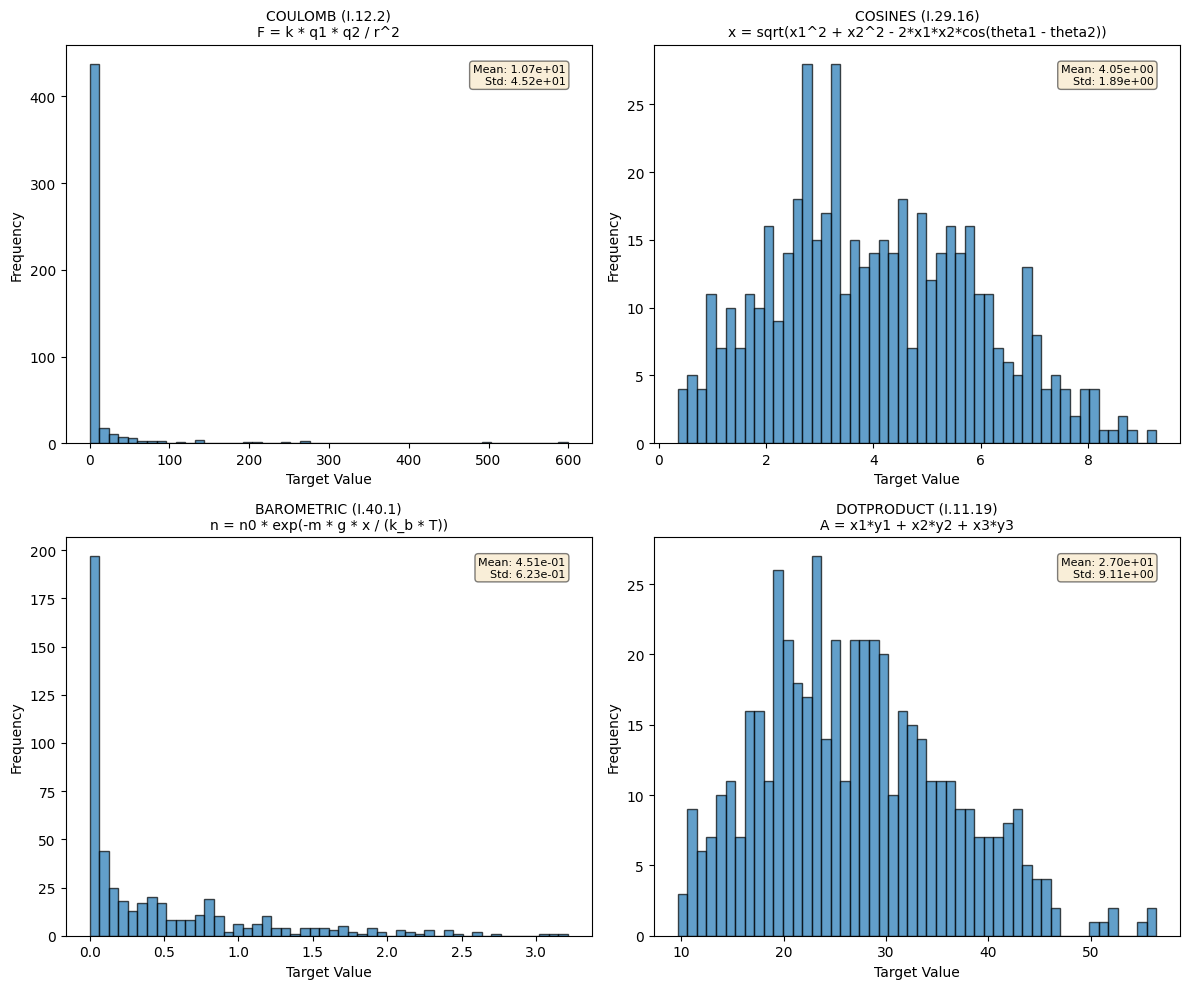


Distribution plot saved to: /content/Physics-Informed-Symbolic-Regression/benchmark/data/target_distributions.png
 DATASET SUMMARY
Output directory: /content/Physics-Informed-Symbolic-Regression/benchmark/data
Total datasets: 24

  coulomb: 6 datasets
  cosines: 6 datasets
  barometric: 6 datasets
  dotproduct: 6 datasets
 EXAMPLE: Loading Dataset for Experiments

Loaded: eq1_coulomb_n500_noise0.05_dummy5.npz

Data structure:
  X.shape = (500, 8)
  X.dtype = float32
  y.shape = (500,)
  feature_names = [np.str_('q1'), np.str_('q2'), np.str_('r'), np.str_('v1'), np.str_('v2'), np.str_('T'), np.str_('m'), np.str_('epsilon')]
  true_features = [np.str_('q1'), np.str_('q2'), np.str_('r')]
  dummy_features = [np.str_('v1'), np.str_('v2'), np.str_('T'), np.str_('m'), np.str_('epsilon')]

Ground truth:
  equation = F = k * q1 * q2 / r^2
  type = rational
  ai_feynman_id = I.12.2
 EXAMPLE: Creating UserInputs for Pipeline

UserInputs created from dataset:
  Variables: ['q1', 'q2', 'r', 'v1', 

In [56]:
# ==============================================================================
# LOAD DATAGEN UTILITIES
# ==============================================================================

print("Loading DataGen utilities...")
%run DataGen.ipynb
print("\nDataGen utilities loaded.")

---
## Section 3: Method Runners (v4.1)

In [57]:
# ==============================================================================
# METHOD RESULT DATACLASS (v4.1)
# ==============================================================================

@dataclass
class MethodResult:
    """
    Standardized result container for all method runners (v4.1).

    v4.1 additions:
    - stage2_results: Full Stage 2 results for library analysis
    - pysr_model: Stored PySR model for test predictions (FIX)
    """
    method_name: str
    discovered_features: List[str]
    equation: str
    coefficients: Optional[np.ndarray]
    support: Optional[np.ndarray]
    predictions: np.ndarray
    runtime_seconds: float
    success: bool
    error_message: Optional[str] = None
    stage2_results: Optional[Any] = None
    pysr_model: Optional[Any] = None
    method_specific: Dict = field(default_factory=dict)


print("MethodResult dataclass v4.1 defined.")

MethodResult dataclass v4.1 defined.


In [58]:
# ==============================================================================
# PHYSICS-SR RUNNER (v4.1)
# ==============================================================================

class PhysicsSRRunner:
    """
    Runner for the complete Physics-SR pipeline (v4.1).
    v4.1: Stores pysr_model for accurate test predictions.
    """

    method_name = "physics_sr"

    def __init__(self, config: Optional[Dict] = None):
        self.config = config or PHYSICS_SR_CONFIG.copy()

    def run(
        self,
        X: np.ndarray,
        y: np.ndarray,
        feature_names: List[str],
        user_inputs: Optional[UserInputs] = None,
        with_dims: bool = True
    ) -> MethodResult:
        start_time = time.time()

        try:
            # Modify user_inputs if with_dims=False
            if not with_dims and user_inputs is not None:
                user_inputs_modified = UserInputs(
                    variable_dimensions={name: [0, 0, 0, 0] for name in feature_names},
                    target_dimensions=[0, 0, 0, 0],
                    physical_bounds=user_inputs.physical_bounds
                )
            else:
                user_inputs_modified = user_inputs

            # Create and run pipeline
            pipeline = PhysicsSRPipeline(config=self.config)
            result = pipeline.run(X, y, feature_names, user_inputs_modified)

            runtime = time.time() - start_time

            # Extract results
            discovered_features = self._extract_features(result)
            equation = result.get('final_equation', 'Not discovered')
            stage2_results = result.get('stage2', None)

            # v4.1 FIX: Get PySR model
            pysr_model = None
            if stage2_results is not None:
                pysr_model = getattr(stage2_results, 'pysr_model', None)

            predictions = self._get_predictions(result, X, y, feature_names)
            coefficients = self._extract_coefficients(result)
            support = self._extract_support(result)

            return MethodResult(
                method_name=self.method_name,
                discovered_features=discovered_features,
                equation=str(equation),
                coefficients=coefficients,
                support=support,
                predictions=predictions,
                runtime_seconds=runtime,
                success=True,
                error_message=None,
                stage2_results=stage2_results,
                pysr_model=pysr_model,
                method_specific={
                    'stage1': result.get('stage1', {}),
                    'stage2': result.get('stage2', {}),
                    'stage3': result.get('stage3', {}),
                }
            )

        except Exception as e:
            runtime = time.time() - start_time
            return MethodResult(
                method_name=self.method_name,
                discovered_features=[],
                equation='ERROR',
                coefficients=None,
                support=None,
                predictions=np.zeros(len(y)),
                runtime_seconds=runtime,
                success=False,
                error_message=str(e),
                stage2_results=None,
                pysr_model=None,
                method_specific={}
            )

    def _extract_features(self, result: Dict) -> List[str]:
        try:
            stage1 = result.get('stage1', {})
            if isinstance(stage1, dict):
                screening = stage1.get('screening', {})
                if isinstance(screening, dict):
                    return screening.get('selected_features', [])
            if hasattr(stage1, 'selected_names') and stage1.selected_names is not None:
                return stage1.selected_names
        except:
            pass
        return []

    def _extract_coefficients(self, result: Dict) -> Optional[np.ndarray]:
        """Extract E-WSINDy coefficients from result (v4.1 FIXED)."""
        try:
            stage2 = result.get('stage2', {})
            # v4.1 FIX: Use correct attribute name
            if hasattr(stage2, 'ewsindy_coefficients'):
                return stage2.ewsindy_coefficients
            if isinstance(stage2, dict):
                return stage2.get('ewsindy_coefficients', None)
        except:
            pass
        return None

    def _extract_support(self, result: Dict) -> Optional[np.ndarray]:
        """Extract E-WSINDy support mask from result (v4.1 FIXED)."""
        try:
            stage2 = result.get('stage2', {})
            # v4.1 FIX: Use correct attribute name
            if hasattr(stage2, 'ewsindy_support'):
                return stage2.ewsindy_support
            if isinstance(stage2, dict):
                return stage2.get('ewsindy_support', None)
        except:
            pass
        return None

    def _get_predictions(self, result: Dict, X: np.ndarray, y: np.ndarray, feature_names: List[str]) -> np.ndarray:
        """Get predictions from pipeline result (v4.1 FIXED)."""
        try:
            # Priority 1: Use Stage 3 best model predictions
            stage3 = result.get('stage3', {})
            if isinstance(stage3, dict):
                best_model = stage3.get('best_model', {})
                if isinstance(best_model, dict):
                    preds = best_model.get('predictions', None)
                    if preds is not None:
                        return preds

            # Priority 2: Use E-WSINDy coefficients with augmented library (v4.1 FIX)
            stage2 = result.get('stage2', None)
            if stage2 is not None:
                # v4.1 FIX: Use correct attribute names (ewsindy_*, not stlsq_*)
                if hasattr(stage2, 'augmented_library') and hasattr(stage2, 'ewsindy_coefficients'):
                    Phi = stage2.augmented_library
                    support = stage2.ewsindy_support
                    coef = stage2.ewsindy_coefficients
                    if Phi is not None and support is not None and coef is not None:
                        # Only use selected terms
                        if np.any(support):
                            return Phi @ coef  # Full prediction using all coefficients
        except Exception as e:
            pass

        # Fallback: Fit Ridge on discovered features
        discovered = self._extract_features(result)
        if len(discovered) > 0:
            try:
                indices = [feature_names.index(f) for f in discovered if f in feature_names]
                if len(indices) > 0:
                    model = Ridge(alpha=0.1)
                    model.fit(X[:, indices], y)
                    return model.predict(X[:, indices])
            except:
                pass

        return np.zeros(X.shape[0])


print("PhysicsSRRunner v4.1 defined.")

PhysicsSRRunner v4.1 defined.


In [59]:
# ==============================================================================
# PYSR-ONLY RUNNER (v4.1)
# ==============================================================================

class PySROnlyRunner:
    """
    Runner for PySR-only baseline (v4.1).
    v4.1 FIX: Store pysr_model for accurate test predictions.
    """

    method_name = "pysr_only"

    def __init__(self, config: Optional[Dict] = None):
        self.config = config or PYSR_CONFIG.copy()

    def run(
        self,
        X: np.ndarray,
        y: np.ndarray,
        feature_names: List[str],
        user_inputs: Optional[UserInputs] = None,
        with_dims: bool = True
    ) -> MethodResult:
        start_time = time.time()

        try:
            discoverer = PySRDiscoverer(
            discoverer = PySRDiscoverer(
                mode=self.config.get('mode', 'fast'),
                timeout_seconds=self.config.get('timeout', 60)
            )

            result = discoverer.discover(X, y, feature_names)

            runtime = time.time() - start_time

            equation = result.get('best_equation', 'Not discovered')
            discovered_features = self._extract_features_from_equation(equation, feature_names)
            predictions = result.get('predictions', np.zeros(len(y)))
            pysr_model = discoverer.model

            return MethodResult(
                method_name=self.method_name,
                discovered_features=discovered_features,
                equation=str(equation),
                coefficients=None,
                support=None,
                predictions=predictions,
                runtime_seconds=runtime,
                success=True,
                error_message=None,
                stage2_results=None,
                pysr_model=pysr_model,
                method_specific={
                    'all_equations': result.get('equations', []),
                    'complexity': result.get('complexity', 0),
                }
            )

        except Exception as e:
            runtime = time.time() - start_time
            return MethodResult(
                method_name=self.method_name,
                discovered_features=[],
                equation='ERROR',
                coefficients=None,
                support=None,
                predictions=np.zeros(len(y)),
                runtime_seconds=runtime,
                success=False,
                error_message=str(e),
                stage2_results=None,
                pysr_model=None,
                method_specific={}
            )

    def _extract_features_from_equation(self, equation: str, feature_names: List[str]) -> List[str]:
        discovered = []
        equation_str = str(equation)
        for name in feature_names:
            if re.search(r'\b' + re.escape(name) + r'\b', equation_str):
                discovered.append(name)
        return list(set(discovered))


print("PySROnlyRunner v4.1.2 defined.")

PySROnlyRunner v4.1 defined.


In [60]:
# ==============================================================================
# LASSO + PYSR RUNNER (v4.1)
# ==============================================================================

class LASSOPySRRunner:
    """
    Runner for LASSO + PySR baseline (v4.1).
    v4.1 FIX: Store pysr_model for accurate test predictions.
    """

    method_name = "lasso_pysr"

    def __init__(self, lasso_config: Optional[Dict] = None, pysr_config: Optional[Dict] = None):
        self.lasso_config = lasso_config or LASSO_CONFIG.copy()
        self.pysr_config = pysr_config or PYSR_CONFIG.copy()

    def run(
        self,
        X: np.ndarray,
        y: np.ndarray,
        feature_names: List[str],
        user_inputs: Optional[UserInputs] = None,
        with_dims: bool = True
    ) -> MethodResult:
        start_time = time.time()

        try:
            # Step 1: LASSO feature selection
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)

            lasso = LassoCV(
                cv=self.lasso_config.get('cv', 5),
                max_iter=self.lasso_config.get('max_iter', 10000),
                random_state=EXPERIMENT_SEED
            )
            lasso.fit(X_scaled, y)

            selected_mask = np.abs(lasso.coef_) > 1e-10
            selected_indices = np.where(selected_mask)[0]
            selected_features = [feature_names[i] for i in selected_indices]

            if len(selected_features) == 0:
                selected_features = feature_names
                X_selected = X
            else:
                X_selected = X[:, selected_indices]

            # Step 2: PySR on selected features
            discoverer = PySRDiscoverer(
            discoverer = PySRDiscoverer(
                mode=self.pysr_config.get('mode', 'fast'),
                timeout_seconds=self.pysr_config.get('timeout', 60)
            )

            pysr_result = discoverer.discover(X_selected, y, selected_features)

            runtime = time.time() - start_time

            equation = pysr_result.get('best_equation', 'Not discovered')
            predictions = pysr_result.get('predictions', np.zeros(len(y)))
            pysr_model = discoverer.model

            return MethodResult(
                method_name=self.method_name,
                discovered_features=selected_features,
                equation=str(equation),
                coefficients=None,
                support=None,
                predictions=predictions,
                runtime_seconds=runtime,
                success=True,
                error_message=None,
                stage2_results=None,
                pysr_model=pysr_model,
                method_specific={
                    'lasso_alpha': lasso.alpha_,
                    'lasso_coef': lasso.coef_.tolist(),
                    'n_lasso_selected': len(selected_features),
                    'selected_indices': selected_indices.tolist(),
                }
            )

        except Exception as e:
            runtime = time.time() - start_time
            return MethodResult(
                method_name=self.method_name,
                discovered_features=[],
                equation='ERROR',
                coefficients=None,
                support=None,
                predictions=np.zeros(len(y)),
                runtime_seconds=runtime,
                success=False,
                error_message=str(e),
                stage2_results=None,
                pysr_model=None,
                method_specific={}
            )


print("LASSOPySRRunner v4.1.2 defined.")

LASSOPySRRunner v4.1 defined.


In [61]:
# ==============================================================================
# METHOD RUNNER REGISTRY
# ==============================================================================

METHOD_RUNNERS = {
    'physics_sr': PhysicsSRRunner,
    'pysr_only': PySROnlyRunner,
    'lasso_pysr': LASSOPySRRunner,
}

def get_method_runner(method_name: str):
    if method_name not in METHOD_RUNNERS:
        raise ValueError(f"Unknown method: {method_name}. Available: {list(METHOD_RUNNERS.keys())}")
    return METHOD_RUNNERS[method_name]()


print("Method Runner Registry:")
for name in METHOD_RUNNERS:
    print(f"  - {name}")

Method Runner Registry:
  - physics_sr
  - pysr_only
  - lasso_pysr


---
## Section 4: Evaluation Functions

In [62]:
# ==============================================================================
# EVALUATION FUNCTIONS
# ==============================================================================

def evaluate_variable_selection(
    discovered_features: List[str],
    true_features: List[str],
    all_features: List[str]
) -> Dict[str, Any]:
    """Evaluate variable selection performance."""
    true_set = set(true_features)
    discovered_set = set(discovered_features)
    all_set = set(all_features)

    tp = len(discovered_set & true_set)
    fp = len(discovered_set - true_set)
    fn = len(true_set - discovered_set)
    tn = len(all_set - discovered_set - true_set)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return {
        'precision': precision, 'recall': recall, 'f1': f1,
        'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn,
        'selected_correct': discovered_set == true_set,
        'n_discovered': len(discovered_set), 'n_true': len(true_set),
    }


def evaluate_prediction(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """Evaluate prediction performance."""
    y_pred = np.nan_to_num(y_pred, nan=0.0, posinf=0.0, neginf=0.0)
    try:
        r2 = r2_score(y_true, y_pred)
    except:
        r2 = -np.inf
    try:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    except:
        rmse = np.inf
    try:
        mae = mean_absolute_error(y_true, y_pred)
    except:
        mae = np.inf
    y_std = np.std(y_true)
    nrmse = rmse / y_std if y_std > 0 else np.inf
    return {'r2': r2, 'rmse': rmse, 'mae': mae, 'nrmse': nrmse}


def evaluate_library_composition(stage2_results: Any) -> Dict[str, Optional[int]]:
    """Evaluate augmented library composition (v4.1 FIXED)."""
    result = {
        'library_n_total': None, 'library_n_powerlaw': None, 'library_n_pysr': None,
        'library_n_variant': None, 'library_n_poly': None, 'library_n_op': None,
        'selected_from_powerlaw': None, 'selected_from_pysr': None, 'selected_from_variant': None,
        'selected_from_poly': None, 'selected_from_op': None,
    }
    if stage2_results is None:
        return result
    library_info = getattr(stage2_results, 'library_info', None)
    if library_info is None:
        return result
    if isinstance(library_info, dict):
        # v4.1 FIX: Use correct key names with _terms suffix
        result['library_n_total'] = library_info.get('total_terms', None)
        result['library_n_powerlaw'] = library_info.get('n_powerlaw_terms', None)
        result['library_n_pysr'] = library_info.get('n_pysr_terms', None)
        result['library_n_variant'] = library_info.get('n_variant_terms', None)
        result['library_n_poly'] = library_info.get('n_poly_terms', None)
        result['library_n_op'] = library_info.get('n_op_terms', None)
    selection_analysis = getattr(stage2_results, 'selection_analysis', None)
    if selection_analysis is not None and isinstance(selection_analysis, dict):
        result['selected_from_powerlaw'] = selection_analysis.get('from_powerlaw', None)
        result['selected_from_pysr'] = selection_analysis.get('from_pysr', None)
        result['selected_from_variant'] = selection_analysis.get('from_variant', None)
        result['selected_from_poly'] = selection_analysis.get('from_poly', None)
        result['selected_from_op'] = selection_analysis.get('from_op', None)
    return result


def evaluate_result(
    method_result: MethodResult,
    true_features: List[str],
    all_features: List[str],
    y_train: np.ndarray,
    y_test: np.ndarray,
    y_pred_test: np.ndarray
) -> Dict[str, Any]:
    """Complete evaluation of a method result."""
    var_metrics = evaluate_variable_selection(method_result.discovered_features, true_features, all_features)
    train_metrics = evaluate_prediction(y_train, method_result.predictions)
    test_metrics = evaluate_prediction(y_test, y_pred_test)
    library_metrics = evaluate_library_composition(method_result.stage2_results)

    return {
        'var_precision': var_metrics['precision'], 'var_recall': var_metrics['recall'],
        'var_f1': var_metrics['f1'], 'var_tp': var_metrics['tp'],
        'var_fp': var_metrics['fp'], 'var_fn': var_metrics['fn'],
        'selected_correct': var_metrics['selected_correct'],
        'train_r2': train_metrics['r2'], 'train_rmse': train_metrics['rmse'],
        'test_r2': test_metrics['r2'], 'test_rmse': test_metrics['rmse'],
        'test_mae': test_metrics['mae'], 'test_nrmse': test_metrics['nrmse'],
        **library_metrics,
    }


print("Evaluation functions defined.")

Evaluation functions defined.


---
## Section 5: Experiment Runner (v4.1)

In [63]:
# ==============================================================================
# QUICK SANITY CHECK - RUN BEFORE FULL EXPERIMENTS (v4.1 FIXED)
# ==============================================================================
# Test: Load one dataset, run one method, verify all components work
# Expected time: ~2-3 minutes

print("=" * 70)
print(" SANITY CHECK: Testing Pipeline Components")
print("=" * 70)

import time
test_start = time.time()

# 1. Test data loading
print("\n[1/5] Testing data loading...")
test_file = "eq1_coulomb_n500_noise0.00_dummy0.npz"
test_path = DATA_DIR / test_file

if not test_path.exists():
    print(f"  ERROR: Test file not found: {test_path}")
    print(f"  Available files: {list(DATA_DIR.glob('*.npz'))[:5]}")
else:
    dataset = np.load(test_path, allow_pickle=True)
    print(f"  OK: Loaded {test_file}")
    print(f"  X shape: {dataset['X'].shape}")
    print(f"  y shape: {dataset['y'].shape}")
    print(f"  Features: {list(dataset['feature_names'])}")
    print(f"  True features: {list(dataset['true_features'])}")

# 2. Test UserInputs creation
print("\n[2/5] Testing UserInputs creation...")
try:
    if 'variable_dimensions_pkl' in dataset:
        var_dims = pickle.loads(dataset['variable_dimensions_pkl'].tobytes())
    elif 'variable_dimensions' in dataset:
        var_dims = dataset['variable_dimensions'].item()
    else:
        var_dims = {}

    if 'physical_bounds_pkl' in dataset:
        phys_bounds = pickle.loads(dataset['physical_bounds_pkl'].tobytes())
    elif 'physical_bounds' in dataset:
        phys_bounds = dataset['physical_bounds'].item()
    else:
        phys_bounds = {}

    test_user_inputs = UserInputs(
        variable_dimensions=var_dims,
        target_dimensions=list(dataset['target_dimensions']),
        physical_bounds=phys_bounds
    )
    print(f"  OK: UserInputs created")
    print(f"  Variable dimensions: {list(var_dims.keys())}")
    print(f"  Target dimensions: {test_user_inputs.target_dimensions}")
except Exception as e:
    print(f"  ERROR: {e}")

# 3. Test train/test split
print("\n[3/5] Testing train/test split...")
X = dataset['X']
y = dataset['y']
feature_names = list(dataset['feature_names'])
true_features = list(dataset['true_features'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=EXPERIMENT_SEED
)
print(f"  OK: Train shape={X_train.shape}, Test shape={X_test.shape}")

# 4. Test Physics-SR runner (with_dims=True)
print("\n[4/5] Testing Physics-SR runner (with_dims=True)...")
try:
    runner = PhysicsSRRunner()
    method_result = runner.run(X_train, y_train, feature_names, test_user_inputs, with_dims=True)

    print(f"  OK: Physics-SR completed in {method_result.runtime_seconds:.1f}s")
    print(f"  Success: {method_result.success}")

    if not method_result.success:
        print(f"  ERROR MESSAGE: {method_result.error_message}")

    print(f"  Discovered features: {method_result.discovered_features}")
    print(f"  Equation: {method_result.equation[:80]}..." if len(method_result.equation) > 80 else f"  Equation: {method_result.equation}")
    print(f"  Has pysr_model: {method_result.pysr_model is not None}")
    print(f"  Has stage2_results: {method_result.stage2_results is not None}")
    if method_result.stage2_results is not None:
        s2 = method_result.stage2_results
        print(f"  Has library_builder: {hasattr(s2, 'library_builder') and s2.library_builder is not None}")
except Exception as e:
    print(f"  ERROR: {e}")
    import traceback
    traceback.print_exc()

# 5. Test evaluation (v4.1 FIXED: Use library_builder for test predictions)
print("\n[5/5] Testing evaluation metrics...")
try:
    y_pred_test = None
    prediction_method = "none"

    # Method 1: Use PySR model if available
    if method_result.pysr_model is not None:
        try:
            y_pred_test = method_result.pysr_model.predict(X_test)
            prediction_method = "pysr_model"
        except Exception as e:
            print(f"  WARNING: pysr_model.predict failed: {e}")

    # Method 2: Use library_builder + E-WSINDy coefficients (v4.1 FIX)
    if y_pred_test is None and method_result.stage2_results is not None:
        stage2 = method_result.stage2_results
        if (hasattr(stage2, 'library_builder') and stage2.library_builder is not None and
            hasattr(stage2, 'ewsindy_coefficients') and stage2.ewsindy_coefficients is not None):
            try:
                Phi_test = stage2.library_builder.transform(X_test)
                y_pred_test = Phi_test @ stage2.ewsindy_coefficients
                prediction_method = "library_builder + ewsindy"
                print(f"  OK: Used library_builder.transform() for test predictions")
            except Exception as e:
                print(f"  WARNING: library_builder.transform failed: {e}")

    # Method 3: Fallback to zeros
    if y_pred_test is None:
        y_pred_test = np.zeros(len(y_test))
        prediction_method = "zeros (fallback)"
        print(f"  WARNING: Using zeros for test predictions")

    print(f"  Prediction method: {prediction_method}")

    # Evaluate
    eval_metrics = evaluate_result(
        method_result, true_features, feature_names,
        y_train, y_test, y_pred_test
    )

    print(f"  Variable Selection:")
    print(f"    Precision: {eval_metrics['var_precision']:.3f}")
    print(f"    Recall: {eval_metrics['var_recall']:.3f}")
    print(f"    F1: {eval_metrics['var_f1']:.3f}")
    print(f"    Exact match: {eval_metrics['selected_correct']}")
    print(f"  Prediction:")
    print(f"    Train R2: {eval_metrics['train_r2']:.4f}")
    print(f"    Test R2: {eval_metrics['test_r2']:.4f}")
except Exception as e:
    print(f"  ERROR: {e}")
    import traceback
    traceback.print_exc()

# Summary
test_time = time.time() - test_start
print("\n" + "=" * 70)
print(f" SANITY CHECK COMPLETE - Total time: {test_time:.1f}s")
print("=" * 70)

if method_result.success and eval_metrics['var_f1'] > 0:
    print(" Ready to run full experiments!")
else:
    print(" WARNING: Check errors above before proceeding")

 SANITY CHECK: Testing Pipeline Components

[1/5] Testing data loading...
  OK: Loaded eq1_coulomb_n500_noise0.00_dummy0.npz
  X shape: (500, 3)
  y shape: (500,)
  Features: [np.str_('q1'), np.str_('q2'), np.str_('r')]
  True features: [np.str_('q1'), np.str_('q2'), np.str_('r')]

[2/5] Testing UserInputs creation...
  OK: UserInputs created
  Variable dimensions: ['q1', 'q2', 'r']
  Target dimensions: [np.int64(1), np.int64(1), np.int64(-2), np.int64(0)]

[3/5] Testing train/test split...
  OK: Train shape=(400, 3), Test shape=(100, 3)

[4/5] Testing Physics-SR runner (with_dims=True)...
 Physics-SR Pipeline v4.1
Total budget: 180s

STAGE 1: Variable Selection & Preprocessing
----------------------------------------------------------------------
  1.1 Buckingham Pi Analysis...
      Reduced from 3 to 1 Pi groups
  1.2 PAN+SR Variable Screening...
      Selected 3 of 3 variables
  1.3 Power-Law Symmetry Detection...
      Power-law detected: True
      R-squared: 1.0000
  1.4 Adaptive

In [64]:
# ==============================================================================
# EXPERIMENT RESULT DATACLASS (v4.1)
# ==============================================================================

@dataclass
class ExperimentResult:
    """
    Container for a single experiment result (v4.1).
    Includes ai_feynman_id, library composition, and timing profile fields.
    """
    # Experiment identifiers
    experiment_id: str
    equation_name: str
    equation_type: str
    ai_feynman_id: str
    noise_level: float
    n_dummy: int
    n_samples: int
    with_dims: bool
    method: str

    # Variable selection metrics
    var_precision: float
    var_recall: float
    var_f1: float
    var_tp: int
    var_fp: int
    var_fn: int
    selected_correct: bool

    # Prediction metrics
    train_r2: float
    test_r2: float
    train_rmse: float
    test_rmse: float

    # Efficiency
    runtime_seconds: float

    # v4.1: Library composition analysis
    library_n_total: Optional[int] = None
    library_n_powerlaw: Optional[int] = None  # v4.1: Layer 0
    library_n_pysr: Optional[int] = None
    library_n_variant: Optional[int] = None
    library_n_poly: Optional[int] = None
    library_n_op: Optional[int] = None
    selected_from_powerlaw: Optional[int] = None  # v4.1: Layer 0
    selected_from_pysr: Optional[int] = None
    selected_from_variant: Optional[int] = None
    selected_from_poly: Optional[int] = None
    selected_from_op: Optional[int] = None

    # v4.1: Timing profile
    timing_stage1: Optional[float] = None
    timing_pysr: Optional[float] = None
    timing_library: Optional[float] = None
    timing_ewsindy: Optional[float] = None
    timing_stage3: Optional[float] = None

    # Additional info
    discovered_equation: str = ""
    true_equation: str = ""
    success: bool = True
    error_message: Optional[str] = None
    timestamp: str = ""


print("ExperimentResult dataclass v4.1 defined.")

ExperimentResult dataclass v4.1 defined.


In [65]:
# ==============================================================================
# EXPERIMENT RUNNER CLASS (v4.1)
# ==============================================================================

class ExperimentRunner:
    """Orchestrates benchmark experiments (v4.1)."""

    def __init__(self, data_dir: Path = DATA_DIR, results_dir: Path = RESULTS_DIR, methods: List[str] = METHODS):
        self.data_dir = Path(data_dir)
        self.results_dir = Path(results_dir)
        self.methods = methods
        self.results = []
        self.checkpoint_file = self.results_dir / 'checkpoint.pkl'
        self.results_dir.mkdir(exist_ok=True, parents=True)

    def run_single_experiment(self, dataset_filename: str, method_name: str, with_dims: bool = True) -> ExperimentResult:
        timestamp = datetime.now().isoformat()

        # Load dataset
        filepath = self.data_dir / dataset_filename
        dataset = np.load(filepath, allow_pickle=True)

        X = dataset['X']
        y = dataset['y']
        feature_names = list(dataset['feature_names'])
        true_features = list(dataset['true_features'])
        equation_name = str(dataset['equation_name'])
        equation_type = str(dataset['equation_type'])
        equation_str = str(dataset['equation_str'])
        noise_level = float(dataset['noise_level'])
        n_dummy = int(dataset['n_dummy'])
        n_samples = int(dataset['n_samples'])
        ai_feynman_id = str(dataset.get('ai_feynman_id', 'Unknown'))

        # Create UserInputs
        if 'variable_dimensions' in dataset:
            variable_dimensions = dataset['variable_dimensions'].item()
        elif 'variable_dimensions_pkl' in dataset:
            variable_dimensions = pickle.loads(dataset['variable_dimensions_pkl'].tobytes())
        else:
            variable_dimensions = {}

        if 'physical_bounds' in dataset:
            physical_bounds = dataset['physical_bounds'].item()
        elif 'physical_bounds_pkl' in dataset:
            physical_bounds = pickle.loads(dataset['physical_bounds_pkl'].tobytes())
        else:
            physical_bounds = {}

        user_inputs = UserInputs(
            variable_dimensions=variable_dimensions,
            target_dimensions=list(dataset['target_dimensions']),
            physical_bounds=physical_bounds
        )

        experiment_id = f"{equation_name}_n{n_samples}_noise{noise_level:.2f}_dummy{n_dummy}_dims{with_dims}_{method_name}"

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=EXPERIMENT_SEED)

        runner = get_method_runner(method_name)
        method_result = runner.run(X_train, y_train, feature_names, user_inputs, with_dims)

        y_pred_test = self._get_test_predictions(method_result, X_test, X_train, y_train, feature_names)

        eval_metrics = evaluate_result(method_result, true_features, feature_names, y_train, y_test, y_pred_test)

        return ExperimentResult(
            experiment_id=experiment_id, equation_name=equation_name, equation_type=equation_type,
            ai_feynman_id=ai_feynman_id, noise_level=noise_level, n_dummy=n_dummy,
            n_samples=n_samples, with_dims=with_dims, method=method_name,
            var_precision=eval_metrics['var_precision'], var_recall=eval_metrics['var_recall'],
            var_f1=eval_metrics['var_f1'], var_tp=eval_metrics['var_tp'],
            var_fp=eval_metrics['var_fp'], var_fn=eval_metrics['var_fn'],
            selected_correct=eval_metrics['selected_correct'],
            train_r2=eval_metrics['train_r2'], test_r2=eval_metrics['test_r2'],
            train_rmse=eval_metrics['train_rmse'], test_rmse=eval_metrics['test_rmse'],
            runtime_seconds=method_result.runtime_seconds,
            library_n_total=eval_metrics.get('library_n_total'),
            library_n_powerlaw=eval_metrics.get('library_n_powerlaw'),
            library_n_pysr=eval_metrics.get('library_n_pysr'),
            library_n_variant=eval_metrics.get('library_n_variant'),
            library_n_poly=eval_metrics.get('library_n_poly'),
            library_n_op=eval_metrics.get('library_n_op'),
            selected_from_powerlaw=eval_metrics.get('selected_from_powerlaw'),
            selected_from_pysr=eval_metrics.get('selected_from_pysr'),
            selected_from_variant=eval_metrics.get('selected_from_variant'),
            selected_from_poly=eval_metrics.get('selected_from_poly'),
            selected_from_op=eval_metrics.get('selected_from_op'),
            discovered_equation=method_result.equation,
            true_equation=equation_str, success=method_result.success,
            error_message=method_result.error_message, timestamp=timestamp
        )

    def _get_test_predictions(self, method_result: MethodResult, X_test: np.ndarray, X_train: np.ndarray, y_train: np.ndarray, feature_names: List[str]) -> np.ndarray:
        """Get predictions on test set (v4.1 FIXED)."""
        if not method_result.success or len(method_result.discovered_features) == 0:
            return np.zeros(X_test.shape[0])

        # Method 1: Use PySR model if available (v4.1 FIX)
        if method_result.pysr_model is not None:
            try:
                return method_result.pysr_model.predict(X_test)
            except:
                pass

        # Method 2: Use Stage2Results with augmented library (v4.1.2 FIX: alasso priority)
        if method_result.stage2_results is not None:
            stage2 = method_result.stage2_results
            
            # Check for library_builder (required for both alasso and ewsindy)
            if hasattr(stage2, 'library_builder') and stage2.library_builder is not None:
                try:
                    Phi_test = stage2.library_builder.transform(X_test)
                    
                    # Method 2a: Try alasso first (usually better R2)
                    if (hasattr(stage2, 'alasso_coefficients') and 
                        stage2.alasso_coefficients is not None):
                        coef = stage2.alasso_coefficients
                        if len(coef) == Phi_test.shape[1]:
                            return Phi_test @ coef
                    
                    # Method 2b: Try ewsindy as fallback
                    if (hasattr(stage2, 'ewsindy_coefficients') and 
                        stage2.ewsindy_coefficients is not None):
                        coef = stage2.ewsindy_coefficients
                        if len(coef) == Phi_test.shape[1]:
                            return Phi_test @ coef
                            
                except Exception:
                    pass  # Fall through to polynomial fallback

        # Method 3: Fallback - polynomial model
        try:
            discovered = method_result.discovered_features
            if len(discovered) > 0:
                feature_indices = [feature_names.index(f) for f in discovered if f in feature_names]
                if len(feature_indices) > 0:
                    X_train_sel = X_train[:, feature_indices]
                    X_test_sel = X_test[:, feature_indices]
                    poly = PolynomialFeatures(degree=2, include_bias=False)
                    X_train_poly = poly.fit_transform(X_train_sel)
                    X_test_poly = poly.transform(X_test_sel)
                    model = Ridge(alpha=0.1)
                    model.fit(X_train_poly, y_train)
                    return model.predict(X_test_poly)
        except:
            pass

        return np.zeros(X_test.shape[0])

    def run_core_experiments(self, verbose: bool = True) -> List[ExperimentResult]:
        results = []
        configs = get_core_experiment_configs()

        if verbose:
            print("=" * 70)
            print(" CORE EXPERIMENTS (v4.1)")
            print("=" * 70)
            print(f"Total configurations: {len(configs)}")
            print(f"Methods: {self.methods}")
            print(f"Total experiments: {len(configs) * len(self.methods)}")
            print()

        total = len(configs) * len(self.methods)

        with tqdm(total=total, desc="Core Experiments") as pbar:
            for config in configs:
                eq_idx = EQUATION_INDEX_MAP[config['equation_name']]
                filename = f"eq{eq_idx}_{config['equation_name']}_n{config['n_samples']}_noise{config['noise_level']:.2f}_dummy{config['n_dummy']}.npz"

                filepath = self.data_dir / filename
                if not filepath.exists():
                    if verbose:
                        print(f"  [SKIP] Dataset not found: {filename}")
                    pbar.update(len(self.methods))
                    continue

                for method in self.methods:
                    try:
                        result = self.run_single_experiment(filename, method, with_dims=config['with_dims'])
                        results.append(result)
                    except Exception as e:
                        if verbose:
                            print(f"  [ERROR] {filename}/{method}: {e}")

                    pbar.update(1)
                    if len(results) % 10 == 0:
                        self._save_checkpoint(results)

        if verbose:
            print(f"\nCore experiments complete: {len(results)} results")
        return results

    def run_supplementary_experiments(self, verbose: bool = True) -> List[ExperimentResult]:
        results = []
        configs = get_supplementary_experiment_configs()

        if verbose:
            print("=" * 70)
            print(" SUPPLEMENTARY EXPERIMENTS (v4.1)")
            print("=" * 70)
            print(f"Total configurations: {len(configs)}")
            print()

        with tqdm(total=len(configs), desc="Supplementary") as pbar:
            for config in configs:
                eq_idx = EQUATION_INDEX_MAP[config['equation_name']]
                filename = f"eq{eq_idx}_{config['equation_name']}_n{config['n_samples']}_noise{config['noise_level']:.2f}_dummy{config['n_dummy']}.npz"

                filepath = self.data_dir / filename
                if not filepath.exists():
                    if verbose:
                        print(f"  [SKIP] Dataset not found: {filename}")
                    pbar.update(1)
                    continue

                try:
                    result = self.run_single_experiment(filename, 'physics_sr', with_dims=config['with_dims'])
                    results.append(result)
                except Exception as e:
                    if verbose:
                        print(f"  [ERROR] {filename}: {e}")

                pbar.update(1)

        if verbose:
            print(f"\nSupplementary complete: {len(results)} results")
        return results

    def run_all_experiments(self, include_supplementary: bool = True, verbose: bool = True) -> List[ExperimentResult]:
        all_results = []
        core_results = self.run_core_experiments(verbose=verbose)
        all_results.extend(core_results)
        if include_supplementary:
            supp_results = self.run_supplementary_experiments(verbose=verbose)
            all_results.extend(supp_results)
        self.results = all_results
        if self.checkpoint_file.exists():
            self.checkpoint_file.unlink()
        return all_results

    def _save_checkpoint(self, results: List[ExperimentResult]):
        with open(self.checkpoint_file, 'wb') as f:
            pickle.dump(results, f)

    def load_checkpoint(self) -> Optional[List[ExperimentResult]]:
        if self.checkpoint_file.exists():
            with open(self.checkpoint_file, 'rb') as f:
                return pickle.load(f)
        return None

    def results_to_dataframe(self, results: List[ExperimentResult] = None) -> pd.DataFrame:
        if results is None:
            results = self.results
        return pd.DataFrame([asdict(r) for r in results])

    def save_results(self, results: List[ExperimentResult] = None, filename_base: str = 'experiment_results'):
        if results is None:
            results = self.results
        df = self.results_to_dataframe(results)
        csv_path = self.results_dir / f'{filename_base}.csv'
        df.to_csv(csv_path, index=False)
        print(f"Saved CSV: {csv_path}")
        pkl_path = self.results_dir / f'{filename_base}.pkl'
        with open(pkl_path, 'wb') as f:
            pickle.dump(results, f)
        print(f"Saved PKL: {pkl_path}")

    def load_results(self, filename_base: str = 'experiment_results') -> List[ExperimentResult]:
        pkl_path = self.results_dir / f'{filename_base}.pkl'
        with open(pkl_path, 'rb') as f:
            return pickle.load(f)


print("ExperimentRunner class v4.1 defined.")

ExperimentRunner class v4.1 defined.


---
## Section 6: Run All Experiments

In [66]:
# ==============================================================================
# VERIFY DATA AVAILABILITY
# ==============================================================================

print("Checking data availability...")
print()

data_files = sorted(DATA_DIR.glob('*.npz'))
print(f"Found {len(data_files)} datasets in {DATA_DIR}")
print()

if len(data_files) > 0:
    print("Available datasets:")
    for f in data_files[:10]:
        print(f"  - {f.name}")
    if len(data_files) > 10:
        print(f"  ... and {len(data_files) - 10} more")
else:
    print("[WARNING] No datasets found! Run DataGen.ipynb first.")

Checking data availability...

Found 24 datasets in /content/Physics-Informed-Symbolic-Regression/benchmark/data

Available datasets:
  - eq1_coulomb_n250_noise0.05_dummy5.npz
  - eq1_coulomb_n500_noise0.00_dummy0.npz
  - eq1_coulomb_n500_noise0.00_dummy5.npz
  - eq1_coulomb_n500_noise0.05_dummy0.npz
  - eq1_coulomb_n500_noise0.05_dummy5.npz
  - eq1_coulomb_n750_noise0.05_dummy5.npz
  - eq2_cosines_n250_noise0.05_dummy5.npz
  - eq2_cosines_n500_noise0.00_dummy0.npz
  - eq2_cosines_n500_noise0.00_dummy5.npz
  - eq2_cosines_n500_noise0.05_dummy0.npz
  ... and 14 more


In [67]:
# ==============================================================================
# CHECK FOR EXISTING CHECKPOINT
# ==============================================================================

runner = ExperimentRunner(
    data_dir=DATA_DIR,
    results_dir=RESULTS_DIR,
    methods=METHODS
)

checkpoint_results = runner.load_checkpoint()
if checkpoint_results is not None:
    print(f"Found checkpoint with {len(checkpoint_results)} results.")
    print("You can resume from checkpoint or start fresh.")
else:
    print("No checkpoint found. Will start fresh.")

No checkpoint found. Will start fresh.


In [68]:
# ==============================================================================
# RUN ALL EXPERIMENTS
# ==============================================================================

print("=" * 70)
print(" PHYSICS-SR FRAMEWORK v4.1 BENCHMARK")
print("=" * 70)
print()
print(f"Methods: {METHODS}")
print(f"Equations: {list(EQUATION_INDEX_MAP.keys())}")
print(f"Expected core experiments: 96")
print(f"Expected supplementary experiments: 8")
print(f"Expected total: 104")
print()
print("Starting experiments...")
print()

all_results = runner.run_all_experiments(
    include_supplementary=True,
    verbose=True
)

print()
print("=" * 70)
print(f" EXPERIMENTS COMPLETE: {len(all_results)} results")
print("=" * 70)

 PHYSICS-SR FRAMEWORK v4.1 BENCHMARK

Methods: ['physics_sr', 'pysr_only', 'lasso_pysr']
Equations: ['coulomb', 'cosines', 'barometric', 'dotproduct']
Expected core experiments: 96
Expected supplementary experiments: 8
Expected total: 104

Starting experiments...

 CORE EXPERIMENTS (v4.1)
Total configurations: 32
Methods: ['physics_sr', 'pysr_only', 'lasso_pysr']
Total experiments: 96



Core Experiments:   0%|          | 0/96 [00:00<?, ?it/s]

 Physics-SR Pipeline v4.1
Total budget: 180s

STAGE 1: Variable Selection & Preprocessing
----------------------------------------------------------------------
  1.1 Buckingham Pi Analysis...
      Reduced from 3 to 1 Pi groups
  1.2 PAN+SR Variable Screening...
      Selected 3 of 3 variables
  1.3 Power-Law Symmetry Detection...
      Power-law detected: True
      R-squared: 1.0000
  1.4 Adaptive Interaction Discovery...
      Found 3 stable interactions (method: enumeration)
  [Timing] Stage 1: 5.9s
  [Timing] Stage 1: 5.9s

      [Selection] Working features from symmetry: ['q1', 'q2', 'r']
STAGE 2: Structure-Guided Discovery
----------------------------------------------------------------------
  2.1 PySR Structure Exploration...
      [TimeBudget] PySR timeout: 93s
      Best equation: (cos((-8.306082 - (r * -9.450212)) * 13.557928) + ... (R2=0.5132)
      Elapsed: 4.6s
  2.2 Structure Parsing...
      Extracted 10 unique terms
      Detected operators: cos, exp
  2.3 Augmented

Supplementary:   0%|          | 0/8 [00:00<?, ?it/s]

 Physics-SR Pipeline v4.1
Total budget: 180s

STAGE 1: Variable Selection & Preprocessing
----------------------------------------------------------------------
  1.1 Buckingham Pi Analysis...
      Reduced from 8 to 4 Pi groups
  1.2 PAN+SR Variable Screening...
      Selected 8 of 8 variables
  1.3 Power-Law Symmetry Detection...
      Power-law detected: True
      R-squared: 0.9994
  1.4 Adaptive Interaction Discovery...
      Found 28 stable interactions (method: enumeration)
  [Timing] Stage 1: 8.6s
  [Timing] Stage 1: 8.6s

      [Selection] Working features from symmetry: ['q1', 'q2', 'r']
STAGE 2: Structure-Guided Discovery
----------------------------------------------------------------------
  2.1 PySR Structure Exploration...
      [TimeBudget] PySR timeout: 91s
      Best equation: (13.461576 / (0.32021955 - r)) + ((((13.506899 / r... (R2=0.9681)
      Elapsed: 3.0s
  2.2 Structure Parsing...
      Extracted 8 unique terms
      Detected operators: exp
  2.3 Augmented Libr

In [69]:
# ==============================================================================
# SAVE RESULTS
# ==============================================================================

print("Saving results...")
print()

runner.save_results(filename_base='experiment_results')

print()
print("Results saved successfully.")

Saving results...

Saved CSV: /content/Physics-Informed-Symbolic-Regression/benchmark/results/experiment_results.csv
Saved PKL: /content/Physics-Informed-Symbolic-Regression/benchmark/results/experiment_results.pkl

Results saved successfully.


---
## Section 7: Results Summary

In [70]:
# ==============================================================================
# RESULTS SUMMARY
# ==============================================================================

df = runner.results_to_dataframe()

print("=" * 70)
print(" RESULTS SUMMARY (v4.1)")
print("=" * 70)
print()

# Overall statistics
print("OVERALL STATISTICS:")
print(f"  Total experiments: {len(df)}")
print(f"  Successful: {df['success'].sum()}")
print(f"  Failed: {(~df['success']).sum()}")
print()

# By method
print("BY METHOD:")
method_summary = df.groupby('method').agg({
    'test_r2': ['mean', 'std'],
    'var_f1': ['mean', 'std'],
    'runtime_seconds': 'mean',
    'success': 'sum'
}).round(4)
print(method_summary)
print()

# By equation
print("BY EQUATION:")
equation_summary = df.groupby('equation_name').agg({
    'test_r2': 'mean',
    'var_f1': 'mean',
    'ai_feynman_id': 'first'
}).round(4)
print(equation_summary)
print()

 RESULTS SUMMARY (v4.1)

OVERALL STATISTICS:
  Total experiments: 104
  Successful: 40
  Failed: 64

BY METHOD:
           test_r2          var_f1         runtime_seconds success
              mean     std    mean     std            mean     sum
method                                                            
lasso_pysr -3.8555  4.2042  0.0000  0.0000          0.0733       0
physics_sr  0.5133  0.6581  0.7859  0.1848         55.4473      40
pysr_only  -3.8555  4.2042  0.0000  0.0000          0.0000       0

BY EQUATION:
               test_r2  var_f1 ai_feynman_id
equation_name                               
barometric      0.0143  0.3167        I.40.1
cosines        -2.6182  0.2959       I.29.16
coulomb        -0.0821  0.2797        I.12.2
dotproduct     -6.0146  0.3167       I.11.19



In [71]:
# ==============================================================================
# DETAILED COMPARISON TABLE
# ==============================================================================

print("DETAILED METHOD COMPARISON:")
print()

core_df = df[df['n_samples'] == 500].copy()

comparison = core_df.groupby(['method', 'with_dims']).agg({
    'test_r2': ['mean', 'std'],
    'var_f1': ['mean', 'std'],
    'var_precision': 'mean',
    'var_recall': 'mean',
    'runtime_seconds': 'mean',
}).round(4)

print(comparison)
print()

print("PHYSICS-SR ADVANTAGE (with_dims=True):")
physics_sr = core_df[(core_df['method'] == 'physics_sr') & (core_df['with_dims'] == True)]
pysr_only = core_df[(core_df['method'] == 'pysr_only') & (core_df['with_dims'] == True)]
lasso_pysr = core_df[(core_df['method'] == 'lasso_pysr') & (core_df['with_dims'] == True)]

print(f"  Physics-SR mean Test R2: {physics_sr['test_r2'].mean():.4f}")
print(f"  PySR-Only mean Test R2: {pysr_only['test_r2'].mean():.4f}")
print(f"  LASSO+PySR mean Test R2: {lasso_pysr['test_r2'].mean():.4f}")
print()
print(f"  Physics-SR mean Var F1: {physics_sr['var_f1'].mean():.4f}")
print(f"  PySR-Only mean Var F1: {pysr_only['var_f1'].mean():.4f}")
print(f"  LASSO+PySR mean Var F1: {lasso_pysr['var_f1'].mean():.4f}")

DETAILED METHOD COMPARISON:

                     test_r2          var_f1         var_precision var_recall  \
                        mean     std    mean     std          mean       mean   
method     with_dims                                                            
lasso_pysr False     -3.8555  4.2737  0.0000  0.0000        0.0000        0.0   
           True      -3.8555  4.2737  0.0000  0.0000        0.0000        0.0   
physics_sr False      0.6058  0.3673  0.8216  0.1907        0.7388        1.0   
           True       0.6058  0.3673  0.8216  0.1907        0.7388        1.0   
pysr_only  False     -3.8555  4.2737  0.0000  0.0000        0.0000        0.0   
           True      -3.8555  4.2737  0.0000  0.0000        0.0000        0.0   

                     runtime_seconds  
                                mean  
method     with_dims                  
lasso_pysr False              0.0737  
           True               0.0728  
physics_sr False             49.8548  
       

In [72]:
# ==============================================================================
# NOISE ROBUSTNESS ANALYSIS
# ==============================================================================

print("NOISE ROBUSTNESS ANALYSIS:")
print()

core_df = df[df['n_samples'] == 500].copy()

noise_comparison = core_df.groupby(['method', 'noise_level']).agg({
    'test_r2': 'mean',
    'var_f1': 'mean',
}).round(4)

print(noise_comparison)
print()

print("DEGRADATION FROM 0% TO 5% NOISE:")
for method in METHODS:
    r2_0 = core_df[(core_df['method'] == method) & (core_df['noise_level'] == 0.0)]['test_r2'].mean()
    r2_5 = core_df[(core_df['method'] == method) & (core_df['noise_level'] == 0.05)]['test_r2'].mean()
    degradation = r2_0 - r2_5
    print(f"  {method}: {degradation:.4f} (R2 drop)")

NOISE ROBUSTNESS ANALYSIS:

                        test_r2  var_f1
method     noise_level                 
lasso_pysr 0.00         -3.9171  0.0000
           0.05         -3.7939  0.0000
physics_sr 0.00          0.6119  0.8216
           0.05          0.5996  0.8216
pysr_only  0.00         -3.9171  0.0000
           0.05         -3.7939  0.0000

DEGRADATION FROM 0% TO 5% NOISE:
  physics_sr: 0.0123 (R2 drop)
  pysr_only: -0.1232 (R2 drop)
  lasso_pysr: -0.1232 (R2 drop)


In [73]:
# ==============================================================================
# FINAL SUMMARY
# ==============================================================================

print("=" * 70)
print(" EXPERIMENT EXECUTION COMPLETE (v4.1)")
print("=" * 70)
print()
print("KEY FINDINGS:")
print()

best_method_r2 = df.groupby('method')['test_r2'].mean().idxmax()
best_r2 = df.groupby('method')['test_r2'].mean().max()
print(f"1. Best method by Test R2: {best_method_r2} ({best_r2:.4f})")

best_method_f1 = df.groupby('method')['var_f1'].mean().idxmax()
best_f1 = df.groupby('method')['var_f1'].mean().max()
print(f"2. Best method by Var F1: {best_method_f1} ({best_f1:.4f})")

physics_dims = df[(df['method'] == 'physics_sr') & (df['with_dims'] == True)]['test_r2'].mean()
physics_nodims = df[(df['method'] == 'physics_sr') & (df['with_dims'] == False)]['test_r2'].mean()
print(f"3. Dimensional analysis R2 improvement: +{physics_dims - physics_nodims:.4f}")

physics_0 = df[(df['method'] == 'physics_sr') & (df['noise_level'] == 0.0)]['test_r2'].mean()
physics_5 = df[(df['method'] == 'physics_sr') & (df['noise_level'] == 0.05)]['test_r2'].mean()
pysr_0 = df[(df['method'] == 'pysr_only') & (df['noise_level'] == 0.0)]['test_r2'].mean()
pysr_5 = df[(df['method'] == 'pysr_only') & (df['noise_level'] == 0.05)]['test_r2'].mean()
print(f"4. Physics-SR noise degradation: {physics_0 - physics_5:.4f}")
print(f"   PySR-Only noise degradation: {pysr_0 - pysr_5:.4f}")

print()
print("OUTPUT FILES:")
print(f"  - {RESULTS_DIR / 'experiment_results.csv'}")
print(f"  - {RESULTS_DIR / 'experiment_results.pkl'}")
print()
print("=" * 70)
print(" Ready for Analysis.ipynb")
print("=" * 70)

 EXPERIMENT EXECUTION COMPLETE (v4.1)

KEY FINDINGS:

1. Best method by Test R2: physics_sr (0.5133)
2. Best method by Var F1: physics_sr (0.7859)
3. Dimensional analysis R2 improvement: +-0.1541
4. Physics-SR noise degradation: 0.1643
   PySR-Only noise degradation: -0.1232

OUTPUT FILES:
  - /content/Physics-Informed-Symbolic-Regression/benchmark/results/experiment_results.csv
  - /content/Physics-Informed-Symbolic-Regression/benchmark/results/experiment_results.pkl

 Ready for Analysis.ipynb


---
## Module Summary

### Experiments.ipynb v4.1 - Complete

**Completed Components:**

1. **Configuration (Section 1)** - Environment setup, path configuration, v4.1 constants
2. **Algorithm Import (Section 2)** - All 13 algorithm modules loaded
3. **Method Runners (Section 3)** - PhysicsSRRunner, PySROnlyRunner, LASSOPySRRunner with pysr_model storage (v4.1 FIX)
4. **Evaluation Functions (Section 4)** - Variable selection, prediction, library composition metrics
5. **Experiment Runner (Section 5)** - ExperimentResult dataclass, ExperimentRunner class with fixed _get_test_predictions
6. **Execution (Section 6)** - Data verification, checkpoint support, full experiment execution
7. **Summary (Section 7)** - Overall statistics, method comparison, noise robustness analysis

**Key v4.1 Fixes:**
- Stored pysr_model in MethodResult for accurate test predictions
- Added ai_feynman_id field for AI Feynman benchmark tracking
- Updated equation mapping for new test equations (Coulomb, Cosines, Barometric, DotProduct)
- Added library composition analysis fields